In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import re
import os
import urllib.request
from tqdm import tqdm
from transformers import BertTokenizer, TFBertForSequenceClassification, AdamWeightDecay
from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam
from transformers import AdamWeightDecay
from matplotlib import rcParams
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns

rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

/opt/anaconda3/envs/ESTsoft_TP_2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
os.makedirs("../01_데이터수집/data", exist_ok=True)

urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/finance_sentiment_corpus/main/finance_data.csv", filename="../01_데이터수집/data/finance_data.csv")

('../01_데이터수집/data/finance_data.csv', <http.client.HTTPMessage at 0x105c6f370>)

In [4]:
data = pd.read_csv('../01_데이터수집/data/finance_data.csv')
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 4846


In [5]:
data

,labels,sentence,kor_sentence
0,neutral,"According to Gran, the company has no plans to...","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,neutral,Technopolis plans to develop in stages an area...,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,negative,The international electronic industry company ...,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,positive,With the new production plant the company woul...,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,positive,According to the company's updated strategy fo...,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."
...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,런던 마켓워치 -- 은행주의 반등이 FTSE 100지수의 약세를 상쇄하지 못하면서 ...
4842,neutral,Rinkuskiai's beer sales fell by 6.5 per cent t...,린쿠스키아의 맥주 판매량은 416만 리터로 6.5% 감소했으며 카우노 알루스의 맥주...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,"영업이익은 2007년 68.8 mn에서 35.4 mn으로 떨어졌으며, 선박 판매 이..."
4844,negative,Net sales of the Paper segment decreased to EU...,페이퍼 부문 순매출은 2008년 2분기 241.1 mn에서 2009년 2분기 221...


In [6]:
data['labels'] = data['labels'].replace(['neutral', 'positive', 'negative'],[0, 1, 2])
data[:5]

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_49300/2806054088.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['labels'] = data['labels'].replace(['neutral', 'positive', 'negative'],[0, 1, 2])


,labels,sentence,kor_sentence
0,0,"According to Gran, the company has no plans to...","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,0,Technopolis plans to develop in stages an area...,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,2,The international electronic industry company ...,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,1,With the new production plant the company woul...,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,1,According to the company's updated strategy fo...,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


In [7]:
del data['sentence']

In [8]:
data[:5]

,labels,kor_sentence
0,0,"Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,0,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,2,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,1,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,1,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


In [9]:
print('결측값 여부 :',data.isnull().values.any())

결측값 여부 : False


In [10]:
print('kor_sentence 열의 유니크한 값 :',data['kor_sentence'].nunique())

kor_sentence 열의 유니크한 값 : 4827


In [11]:
duplicate = data[data.duplicated()]

In [12]:
duplicate

,labels,kor_sentence
1099,0,이 발표 내용에 대한 책임은 전적으로 발행자에게 있습니다.
1394,0,"핀란드 헬싱키에 본사를 둔 레민카이넨 그룹은 토목 공학, 건축 계약, 기술 건축 서..."
1416,0,"이 보고서는 블랙 앤 데커, 피스카스, 피스카스 브랜드, 후스크바르나 아웃도어 프로..."
2396,0,알스트롬의 주가는 나스닥 OMX 헬싱키에서 인용되고 있다.
2567,0,SSH 통신 보안 코퍼레이션은 핀란드 헬싱키에 본사를 두고 있다.
2889,0,재정적인 세부사항은 공개되지 않았다.
2890,0,재정적인 세부사항은 공개되지 않았다.
2892,0,금융 조건은 공개되지 않았다.
3050,0,재정적인 세부사항은 제공되지 않았다.
3051,0,재정적인 세부사항은 공개되지 않았다.


In [13]:
# 중복 제거
data.drop_duplicates(subset=['kor_sentence'], inplace=True)
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 4827


<Axes: xlabel='labels'>

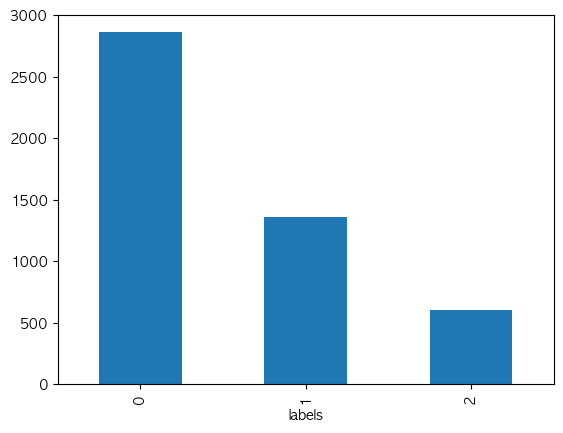

In [14]:
data['labels'].value_counts().plot(kind='bar')

In [15]:
print('레이블의 분포')
print(data.groupby('labels').size().reset_index(name='count'))

레이블의 분포
   labels  count
0       0   2861
1       1   1362
2       2    604


In [16]:
print(f'중립의 비율 = {round(data["labels"].value_counts()[0]/len(data) * 100,3)}%')
print(f'긍정의 비율 = {round(data["labels"].value_counts()[1]/len(data) * 100,3)}%')
print(f'부정의 비율 = {round(data["labels"].value_counts()[2]/len(data) * 100,3)}%')

중립의 비율 = 59.271%
긍정의 비율 = 28.216%
부정의 비율 = 12.513%


In [17]:
data

,labels,kor_sentence
0,0,"Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,0,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,2,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,1,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,1,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."
...,...,...
4841,2,런던 마켓워치 -- 은행주의 반등이 FTSE 100지수의 약세를 상쇄하지 못하면서 ...
4842,0,린쿠스키아의 맥주 판매량은 416만 리터로 6.5% 감소했으며 카우노 알루스의 맥주...
4843,2,"영업이익은 2007년 68.8 mn에서 35.4 mn으로 떨어졌으며, 선박 판매 이..."
4844,2,페이퍼 부문 순매출은 2008년 2분기 241.1 mn에서 2009년 2분기 221...


In [18]:
X_data = data['kor_sentence']
y_data = data['labels']
print('본문의 개수: {}'.format(len(X_data)))
print('레이블의 개수: {}'.format(len(y_data)))

본문의 개수: 4827
레이블의 개수: 4827


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0, stratify=y_data)

In [20]:
print('훈련 샘플의 개수 :', len(X_train))
print('테스트 샘플의 개수 :', len(X_test))

훈련 샘플의 개수 : 3861
테스트 샘플의 개수 : 966


In [21]:
print('--------훈련 데이터의 비율-----------')
print(f'중립 = {round(y_train.value_counts()[0]/len(y_train) * 100,3)}%')
print(f'긍정 = {round(y_train.value_counts()[1]/len(y_train) * 100,3)}%')
print(f'부정 = {round(y_train.value_counts()[2]/len(y_train) * 100,3)}%')

--------훈련 데이터의 비율-----------
중립 = 59.285%
긍정 = 28.205%
부정 = 12.51%


In [22]:
print('--------테스트 데이터의 비율-----------')
print(f'중립 = {round(y_test.value_counts()[0]/len(y_test) * 100,3)}%')
print(f'긍정 = {round(y_test.value_counts()[1]/len(y_test) * 100,3)}%')
print(f'부정 = {round(y_test.value_counts()[2]/len(y_test) * 100,3)}%')

--------테스트 데이터의 비율-----------
중립 = 59.213%
긍정 = 28.261%
부정 = 12.526%


In [23]:
max_seq_len = 128

In [24]:
tokenizer = BertTokenizer.from_pretrained('klue/bert-base')

In [25]:
# def convert_examples_to_features(examples, labels, max_seq_len, tokenizer):

#     input_ids, attention_masks, token_type_ids, data_labels = [], [], [], []

#     for example, label in tqdm(zip(examples, labels), total=len(examples)):
#         # input_id는 워드 임베딩을 위한 문장의 정수 인코딩
#         input_id = tokenizer.encode(example, max_length=max_seq_len, pad_to_max_length=True)

#         # attention_mask는 실제 단어가 위치하면 1, 패딩의 위치에는 0인 시퀀스.
#         padding_count = input_id.count(tokenizer.pad_token_id)
#         attention_mask = [1] * (max_seq_len - padding_count) + [0] * padding_count

#         # token_type_id은 세그먼트 인코딩
#         token_type_id = [0] * max_seq_len

#         assert len(input_id) == max_seq_len, "Error with input length {} vs {}".format(len(input_id), max_seq_len)
#         assert len(attention_mask) == max_seq_len, "Error with attention mask length {} vs {}".format(len(attention_mask), max_seq_len)
#         assert len(token_type_id) == max_seq_len, "Error with token type length {} vs {}".format(len(token_type_id), max_seq_len)

#         input_ids.append(input_id)
#         attention_masks.append(attention_mask)
#         token_type_ids.append(token_type_id)
#         data_labels.append(label)

#     input_ids = np.array(input_ids, dtype=int)
#     attention_masks = np.array(attention_masks, dtype=int)
#     token_type_ids = np.array(token_type_ids, dtype=int)

#     data_labels = np.asarray(data_labels, dtype=np.int32)

#     return (input_ids, attention_masks, token_type_ids), data_labels

In [26]:
def convert_examples_to_features(examples, labels, max_seq_len, tokenizer):
    input_ids, attention_masks, token_type_ids, data_labels = [], [], [], []

    for example, label in tqdm(zip(examples, labels), total=len(examples)):
        encoding = tokenizer(
            example,
            max_length=max_seq_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True,
            return_attention_mask=True
        )

        input_id = encoding['input_ids']
        attention_mask = encoding['attention_mask']
        token_type_id = encoding['token_type_ids']

        # 디버깅용 안전검사
        assert len(input_id) == max_seq_len, f"Error with input length {len(input_id)} vs {max_seq_len}"
        assert len(attention_mask) == max_seq_len, f"Error with attention mask length {len(attention_mask)} vs {max_seq_len}"
        assert len(token_type_id) == max_seq_len, f"Error with token type length {len(token_type_id)} vs {max_seq_len}"

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        data_labels.append(label)

    input_ids = np.array(input_ids, dtype=int)
    attention_masks = np.array(attention_masks, dtype=int)
    token_type_ids = np.array(token_type_ids, dtype=int)
    data_labels = np.asarray(data_labels, dtype=np.int32)

    return (input_ids, attention_masks, token_type_ids), data_labels

In [27]:
train_X, train_y = convert_examples_to_features(X_train, y_train, max_seq_len=max_seq_len, tokenizer=tokenizer)

100%|██████████| 3861/3861 [00:00<00:00, 5887.29it/s]


In [28]:
test_X, test_y = convert_examples_to_features(X_test, y_test, max_seq_len=max_seq_len, tokenizer=tokenizer)

100%|██████████| 966/966 [00:00<00:00, 5915.28it/s]


In [29]:
input_id = train_X[0][0]
attention_mask = train_X[1][0]
token_type_id = train_X[2][0]
label = train_y[0]

print('단어에 대한 정수 인코딩 :',input_id)
print('어텐션 마스크 :',attention_mask)
print('세그먼트 인코딩 :',token_type_id)
print('각 인코딩의 길이 :', len(input_id))
print('정수 인코딩 복원 :',tokenizer.decode(input_id))
print('레이블 :',label)

단어에 대한 정수 인코딩 : [    2  4048  2063  2259 10735  2147  2227  2079  8660 27135 10735  2147
  4401  4286  2205  2259  4946  2052  4169  2085   575  6233  4045 19521
  1513  2062    18     3     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
어텐션 마스크 : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [30]:
# TPU 작동을 위한 코드
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
# tf.config.experimental_connect_to_cluster(resolver)
# tf.tpu.experimental.initialize_tpu_system(resolver)

# strategy = tf.distribute.experimental.TPUStrategy(resolver)

In [31]:
# with strategy.scope():
#   model = TFBertForSequenceClassification.from_pretrained("klue/bert-base", num_labels=3, from_pt=True)
#   optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
#   loss = tf.keras.losses.SparseCategoricalCrossentropy()
#   model.compile(optimizer=optimizer, loss=model.compute_loss, metrics = ['accuracy'])

In [32]:
# early_stopping = EarlyStopping(
#     monitor="val_accuracy", 
#     min_delta=0.001,
#     patience=2)

# model.fit(
#     train_X, train_y, epochs=2, batch_size=32, validation_split=0.2,
#     callbacks = [early_stopping]
# )

In [33]:
# # 모델과 토크나이저 준비
# tokenizer = BertTokenizer.from_pretrained("klue/bert-base")
# model = TFBertForSequenceClassification.from_pretrained("klue/bert-base", num_labels=3, from_pt=True)
# optimizer = AdamWeightDecay(learning_rate=5e-5, weight_decay_rate=0.01)

# # 데이터
# input_ids, attention_masks, token_type_ids = train_X
# labels = train_y

# batch_size = 32
# epochs = 2
# steps_per_epoch = len(input_ids) // batch_size
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# # 수동 학습 루프
# for epoch in range(epochs):
#     print(f"\nEpoch {epoch+1}/{epochs}")
#     total_loss, total_acc = 0.0, 0.0

#     for step in tqdm(range(steps_per_epoch)):
#         start = step * batch_size
#         end = start + batch_size

#         batch_inputs = {
#             "input_ids": input_ids[start:end],
#             "attention_mask": attention_masks[start:end],
#             "token_type_ids": token_type_ids[start:end]
#         }
#         batch_labels = labels[start:end]

#         with tf.GradientTape() as tape:
#             outputs = model(batch_inputs, training=True)
#             logits = outputs.logits
#             loss = loss_fn(batch_labels, logits)
#             preds = tf.argmax(logits, axis=1)
#             acc = tf.reduce_mean(tf.cast(tf.equal(preds, batch_labels), tf.float32))

#         grads = tape.gradient(loss, model.trainable_variables)
#         optimizer.apply_gradients(zip(grads, model.trainable_variables))

#         total_loss += loss.numpy()
#         total_acc += acc.numpy()

#         if step % 10 == 0:
#             print(f"Step {step}/{steps_per_epoch} - Loss: {loss:.4f} - Acc: {acc:.4f}")

#     print(f"Epoch {epoch+1} - Avg Loss: {total_loss/steps_per_epoch:.4f} - Avg Acc: {total_acc/steps_per_epoch:.4f}")

In [34]:
# 모델과 토크나이저 준비
tokenizer = BertTokenizer.from_pretrained("klue/bert-base")
model = TFBertForSequenceClassification.from_pretrained("klue/bert-base", num_labels=3, from_pt=True)
optimizer = AdamWeightDecay(learning_rate=5e-5, weight_decay_rate=0.01)

# 데이터
input_ids, attention_masks, token_type_ids = train_X
labels = train_y

batch_size = 32
epochs = 2
steps_per_epoch = len(input_ids) // batch_size
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

loss_step_history = []
acc_step_history = []

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    total_loss, total_acc = 0.0, 0.0

    for step in tqdm(range(steps_per_epoch)):
        start = step * batch_size
        end = start + batch_size

        batch_inputs = {
            "input_ids": input_ids[start:end],
            "attention_mask": attention_masks[start:end],
            "token_type_ids": token_type_ids[start:end]
        }
        batch_labels = labels[start:end]

        with tf.GradientTape() as tape:
            outputs = model(batch_inputs, training=True)
            logits = outputs.logits
            loss = loss_fn(batch_labels, logits)
            preds = tf.argmax(logits, axis=1)
            acc = tf.reduce_mean(tf.cast(tf.equal(preds, batch_labels), tf.float32))

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        loss_value = loss.numpy()
        acc_value = acc.numpy()

        total_loss += loss_value
        total_acc += acc_value

        loss_step_history.append(loss_value)
        acc_step_history.append(acc_value)

        if step % 10 == 0:
            print(f"Step {step}/{steps_per_epoch} - Loss: {loss:.4f} - Acc: {acc:.4f}")

    print(f"Epoch {epoch+1} - Avg Loss: {total_loss/steps_per_epoch:.4f} - Avg Acc: {total_acc/steps_per_epoch:.4f}")

2025-06-29 18:34:59.898412: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-06-29 18:34:59.898473: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-06-29 18:34:59.898488: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-06-29 18:34:59.898526: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-29 18:34:59.898547: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of t


Epoch 1/2


  1%|          | 1/120 [00:15<31:09, 15.71s/it]

Step 0/120 - Loss: 1.1557 - Acc: 0.2500


  9%|▉         | 11/120 [00:54<05:15,  2.89s/it]

Step 10/120 - Loss: 0.7335 - Acc: 0.6562


 18%|█▊        | 21/120 [01:21<04:08,  2.51s/it]

Step 20/120 - Loss: 0.5542 - Acc: 0.7500


 26%|██▌       | 31/120 [02:00<05:58,  4.03s/it]

Step 30/120 - Loss: 0.6883 - Acc: 0.6562


 34%|███▍      | 41/120 [02:27<03:46,  2.87s/it]

Step 40/120 - Loss: 0.5098 - Acc: 0.7500


 42%|████▎     | 51/120 [03:04<03:38,  3.16s/it]

Step 50/120 - Loss: 0.3698 - Acc: 0.8750


 51%|█████     | 61/120 [03:30<02:26,  2.48s/it]

Step 60/120 - Loss: 0.3834 - Acc: 0.8750


 59%|█████▉    | 71/120 [03:58<02:00,  2.45s/it]

Step 70/120 - Loss: 0.6479 - Acc: 0.7188


 68%|██████▊   | 81/120 [04:20<01:23,  2.15s/it]

Step 80/120 - Loss: 0.4384 - Acc: 0.8125


 76%|███████▌  | 91/120 [04:45<01:12,  2.51s/it]

Step 90/120 - Loss: 0.3953 - Acc: 0.8438


 84%|████████▍ | 101/120 [05:10<00:46,  2.44s/it]

Step 100/120 - Loss: 0.6020 - Acc: 0.7812


 92%|█████████▎| 111/120 [05:33<00:22,  2.49s/it]

Step 110/120 - Loss: 0.3936 - Acc: 0.8438


100%|██████████| 120/120 [05:56<00:00,  2.97s/it]


Epoch 1 - Avg Loss: 0.5164 - Avg Acc: 0.7797

Epoch 2/2


  1%|          | 1/120 [00:03<06:33,  3.31s/it]

Step 0/120 - Loss: 0.3227 - Acc: 0.9375


  9%|▉         | 11/120 [00:31<04:44,  2.61s/it]

Step 10/120 - Loss: 0.2161 - Acc: 0.9062


 18%|█▊        | 21/120 [00:54<04:06,  2.49s/it]

Step 20/120 - Loss: 0.2030 - Acc: 0.9688


 26%|██▌       | 31/120 [01:20<03:54,  2.63s/it]

Step 30/120 - Loss: 0.1602 - Acc: 0.9062


 34%|███▍      | 41/120 [01:43<03:08,  2.38s/it]

Step 40/120 - Loss: 0.3077 - Acc: 0.9375


 42%|████▎     | 51/120 [02:06<02:33,  2.23s/it]

Step 50/120 - Loss: 0.0701 - Acc: 1.0000


 51%|█████     | 61/120 [02:31<02:28,  2.52s/it]

Step 60/120 - Loss: 0.1530 - Acc: 0.9062


 59%|█████▉    | 71/120 [02:55<01:50,  2.25s/it]

Step 70/120 - Loss: 0.2007 - Acc: 0.9375


 68%|██████▊   | 81/120 [03:17<01:25,  2.20s/it]

Step 80/120 - Loss: 0.1088 - Acc: 0.9688


 76%|███████▌  | 91/120 [03:40<01:03,  2.19s/it]

Step 90/120 - Loss: 0.0282 - Acc: 1.0000


 84%|████████▍ | 101/120 [04:02<00:40,  2.15s/it]

Step 100/120 - Loss: 0.2248 - Acc: 0.9062


 92%|█████████▎| 111/120 [04:25<00:20,  2.30s/it]

Step 110/120 - Loss: 0.0800 - Acc: 1.0000


100%|██████████| 120/120 [04:48<00:00,  2.40s/it]

Epoch 2 - Avg Loss: 0.1735 - Avg Acc: 0.9385


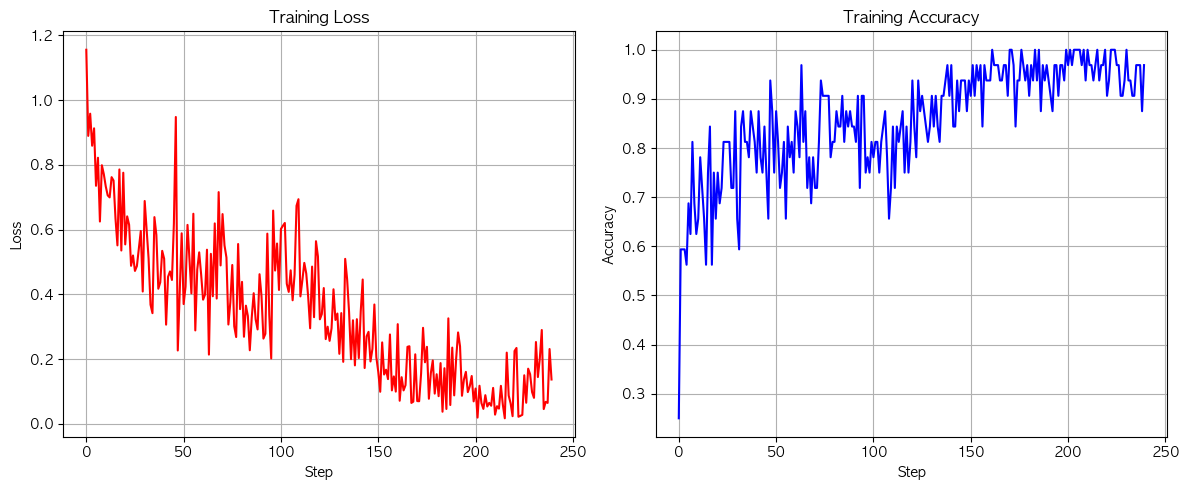

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_step_history, label="Step Loss", color="red")
plt.title("Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(acc_step_history, label="Step Accuracy", color="blue")
plt.title("Training Accuracy")
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

In [43]:
# 모델과 토크나이저 저장
model.save_pretrained("saved_model/klue-bert-sentiment")
tokenizer.save_pretrained("saved_model/klue-bert-sentiment")

('saved_model/klue-bert-sentiment/tokenizer_config.json',
 'saved_model/klue-bert-sentiment/special_tokens_map.json',
 'saved_model/klue-bert-sentiment/vocab.txt',
 'saved_model/klue-bert-sentiment/added_tokens.json')

In [44]:
# model.evaluate(test_X, test_y, batch_size=1024)

In [45]:
# 필요 시 사용 해당 셀은 이미 전의 내용에 포함되어 있음

# 모델과 토크나이저 load
model = TFBertForSequenceClassification.from_pretrained("saved_model/klue-bert-sentiment")
tokenizer = BertTokenizer.from_pretrained("saved_model/klue-bert-sentiment")

# 데이터 로드
df = pd.read_csv("../01_데이터수집/data/finance_data.csv").drop_duplicates(subset=["kor_sentence"])
df["labels"] = df["labels"].replace({"neutral": 0, "positive": 1, "negative": 2})
X_train, X_test, y_train, y_test = train_test_split(df["kor_sentence"], df["labels"], test_size=0.2, stratify=df["labels"], random_state=42)

# 토큰화 함수 정의
def convert_examples_to_features(examples, labels, max_seq_len, tokenizer):
    input_ids, attention_masks, token_type_ids, data_labels = [], [], [], []

    for example, label in tqdm(zip(examples, labels), total=len(examples)):
        encoding = tokenizer(
            example,
            max_length=max_seq_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True,
            return_attention_mask=True
        )

        input_id = encoding['input_ids']
        attention_mask = encoding['attention_mask']
        token_type_id = encoding['token_type_ids']

        # 길이 검사 (디버깅용)
        assert len(input_id) == max_seq_len
        assert len(attention_mask) == max_seq_len
        assert len(token_type_id) == max_seq_len

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        data_labels.append(label)

    input_ids = np.array(input_ids, dtype=int)
    attention_masks = np.array(attention_masks, dtype=int)
    token_type_ids = np.array(token_type_ids, dtype=int)
    data_labels = np.asarray(data_labels, dtype=np.int32)

    return (input_ids, attention_masks, token_type_ids), data_labels

# 테스트셋 변환
test_X, test_y = convert_examples_to_features(X_test.tolist(), y_test.tolist(), max_seq_len=128, tokenizer=tokenizer)

Some layers from the model checkpoint at saved_model/klue-bert-sentiment were not used when initializing TFBertForSequenceClassification: ['dropout_75']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at saved_model/klue-bert-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.
/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/

In [50]:
# 평가
batch_size = 64
steps = len(test_X[0]) // batch_size
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

test_loss_history = []
test_acc_history = []

total_loss, total_acc = 0.0, 0.0
all_preds, all_labels = [], []

for step in tqdm(range(steps)):
    start = step * batch_size
    end = start + batch_size

    batch_inputs = {
        "input_ids": test_X[0][start:end],
        "attention_mask": test_X[1][start:end],
        "token_type_ids": test_X[2][start:end]
    }
    batch_labels = test_y[start:end]

    outputs = model(batch_inputs, training=False)
    logits = outputs.logits
    loss = loss_fn(batch_labels, logits)
    preds = tf.argmax(logits, axis=1)
    acc = tf.reduce_mean(tf.cast(tf.equal(preds, batch_labels), tf.float32))

    loss_value = loss.numpy()
    acc_value = acc.numpy()

    total_loss += loss_value
    total_acc += acc_value

    test_loss_history.append(loss_value)
    test_acc_history.append(acc_value)

    all_preds.extend(preds.numpy())
    all_labels.extend(batch_labels)

    if step % 10 == 0:
        print(f"Step {step}/{steps} - Loss: {loss_value:.4f} - Acc: {acc_value:.4f}")

print(f"\nTest - Avg Loss: {total_loss / steps:.4f} - Avg Acc: {total_acc / steps:.4f}")

  0%|          | 0/15 [00:00<?, ?it/s]

  7%|▋         | 1/15 [00:00<00:12,  1.12it/s]

Step 0/15 - Loss: 0.2682 - Acc: 0.8750


 73%|███████▎  | 11/15 [00:05<00:01,  2.01it/s]

Step 10/15 - Loss: 0.2355 - Acc: 0.9375


100%|██████████| 15/15 [00:07<00:00,  1.92it/s]


Test - Avg Loss: 0.2145 - Avg Acc: 0.9323


Macro F1 Score: 0.9256547735178805
Weighted F1 Score: 0.9313793772614445

Classification Report:
               precision    recall  f1-score   support

          중립     0.9180    0.9807    0.9483       571
          긍정     0.9500    0.8444    0.8941       270
          부정     0.9727    0.8992    0.9345       119

    accuracy                         0.9323       960
   macro avg     0.9469    0.9081    0.9257       960
weighted avg     0.9338    0.9323    0.9314       960



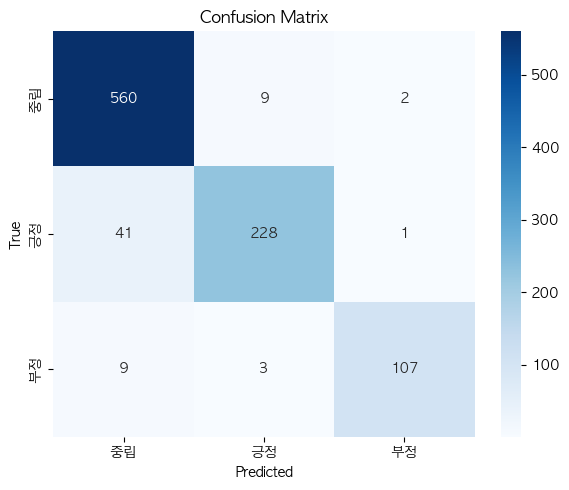

In [51]:
# 결과 출력
print("Macro F1 Score:", f1_score(all_labels, all_preds, average='macro'))
print("Weighted F1 Score:", f1_score(all_labels, all_preds, average='weighted'))
print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=["중립", "긍정", "부정"], digits=4))

# 혼동 행렬 시각화
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["중립", "긍정", "부정"],
            yticklabels=["중립", "긍정", "부정"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

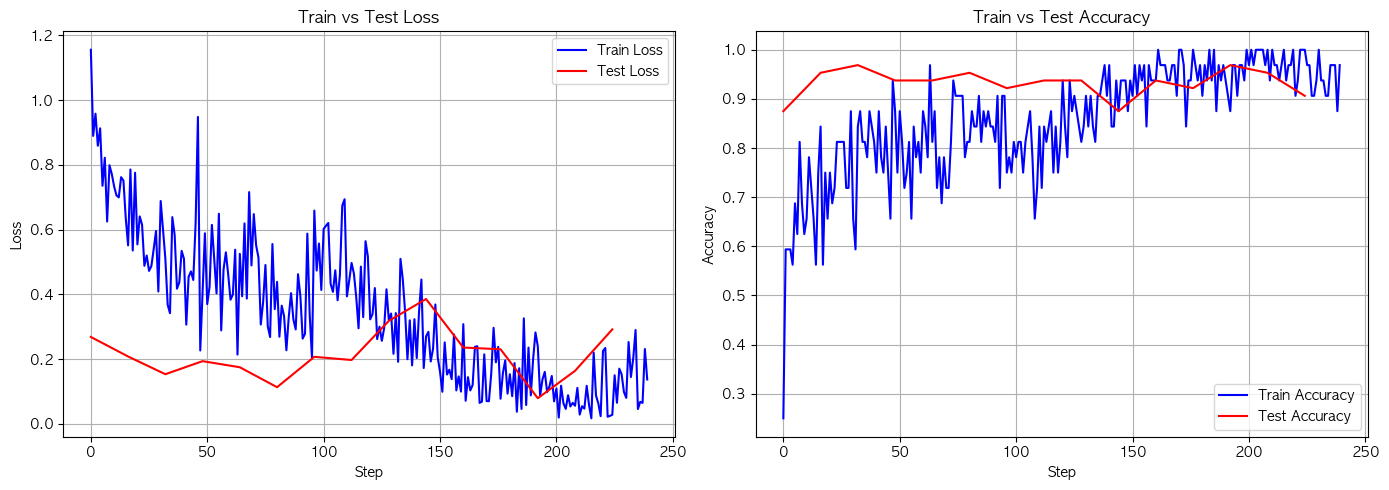

In [52]:
# 스텝 정보
train_steps = list(range(len(loss_step_history)))
test_steps = list(range(0, len(loss_step_history), len(loss_step_history) // len(test_loss_history)))

# 시각화
plt.figure(figsize=(14, 5))

# 1. Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(train_steps, loss_step_history, label='Train Loss', color='blue')
plt.plot(test_steps, test_loss_history, label='Test Loss', color='red')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Train vs Test Loss")
plt.legend()
plt.grid(True)

# 2. Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(train_steps, acc_step_history, label='Train Accuracy', color='blue')
plt.plot(test_steps, test_acc_history, label='Test Accuracy', color='red')
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()